# Siamese-BiLSTM with Features(tm+nlp)
- A new model based on feature_engineering and Siamese-BiLSTM
- Adding features in `feature_nlp.csv` and `feature_tm.csv` (my previous work on feature engineering) to features in the LSTM based neural network structure.
- New: using BiLSTM adding around 40 more features to leaky features, and doubled N_DENSE in Dense layer (to achieve a balance of lstm nn features and adding features). (from N_DENSE/2 to N_DENSE).

    
- **Output:**
  - `lstm_featured.csv`: 4 epoch, score: 0.16515, **best score in our project**
    - 1st epoch: loss: 0.2489 - acc: 0.8280 - val_loss: 0.1927 - val_acc: 0.8630
    - last epoch: loss: 0.1790 - acc: 0.8714 - val_loss: 0.1700 - val_acc: 0.8723

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import re
import csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from string import punctuation
from collections import defaultdict
# from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Keras package
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, LSTM, Lambda,Conv1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.pooling import GlobalAveragePooling1D
import keras.backend as K


In [6]:
#wget http://nlp.stanford.edu/data/glove.840B.300d.zip
#unzip glove.840B.300d.zip

In [3]:
# Hyperparameter defination

# Use the following instructions to download glove and unzip it, if already installed, just comment them.
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip glove.840B.300d.zip
EMBEDDING_FILE = '/content/drive/MyDrive/Project/glove.840B.300d.txt'

TRAIN_DATA_FILE = '/content/drive/MyDrive/Project/train.csv.zip'
TEST_DATA_FILE = '/content/drive/MyDrive/Project/new_test.csv'

MAX_SEQUENCE_LENGTH = 60  
MAX_NUM_WORDS = 200000  # There are about 201000 unique words in training dataset, 200000 is enough for tokenization
EMBEDDING_DIM = 300  # word-embedded-vector dimension(300 is for 'glove.840B.300d')
VALIDATION_SPLIT_RATE = 0.1 
N_HIDDEN = np.random.randint(175, 275)  # 250
N_DENSE = np.random.randint(100, 150)  # 120
DROPOUT_RATE_LSTM = 0.15 + np.random.rand() * 0.25  # drop-out possibility, random set to avoid outfitting  # 0.20
DROUPOUT_RATE_DENSE = 0.15 + np.random.rand() * 0.25  # 0.20

VERSION = 'lstm_featured'
print('LSTM Stucture:')
print('Num_Lstm:', N_HIDDEN)
print('Num_Dense:', N_DENSE)
print('Dropout rate in LSTM layer:', DROPOUT_RATE_LSTM) 
print('Dropout rate in Dense layer::', DROUPOUT_RATE_DENSE)

ACTIVE_FUNC = 'relu'
re_weight = True  # whether to re-weight classes to fit the 17.4% share in test set


LSTM Stucture:
Num_Lstm: 189
Num_Dense: 137
Dropout rate in LSTM layer: 0.15409333214821905
Dropout rate in Dense layer:: 0.17714767347354465


In [4]:
# Create word embedding dictionary from 'glove.840B.300d.txt', {key:value} is {word: glove vector(300,)}
print('Create word embedding dictionary')

embeddings_index = {}  # the output dictionary
f = open(EMBEDDING_FILE, encoding='utf-8')
for line in f:  # tqdm
    values = line.split()
    word = ''.join(values[:-300])   
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors of glove.'.format(len(embeddings_index)))


# Preprocess text in dataset
print('Processing text dataset')

def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        text = [w for w in text if not w in stop_words]
    
    text = " ".join(text)

    # Use re to clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    # text = re.sub(r"\0s", "0", text) # It doesn't make sense to me
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    # or nltk package
    # if lemma:
    #    text = text.split()
    #    wn = nltk.WordNetLemmatizer()
    #    lemm_words = [wn.lemmatize(word) for word in text]
    #    text = " ".join(lemm_words)
    
    # Return a list of words
    return(text)

# Load training data and process with text_to_wordlist (Preprocessing)
train_texts_1 = []  # the preprocessed text of q1
train_texts_2 = []  # the preprocessed text of q2
train_labels = []  # training labels

df_train = pd.read_csv(TRAIN_DATA_FILE, encoding='utf-8')  # the original training data
df_train = df_train.fillna('empty')
#train_q1 = df_train.question1.values  # the original text of q1
#train_q2 = df_train.question2.values  # the original text fo q2
train_labels = df_train.is_duplicate.values  # the original label('is_duplicate')

for text in df_train.question1.values:
    train_texts_1.append(text_to_wordlist(text, remove_stopwords=False, stem_words=False))
    
for text in df_train.question2.values:
    train_texts_2.append(text_to_wordlist(text, remove_stopwords=False, stem_words=False))

print('{} texts are found in train.csv'.format(len(train_texts_1)))

# Load testing data and process with text_to_wordlist (Preprocessing)
test_texts_1 = []  # the preprocessed text of q1_test
test_texts_2 = []  # the preprocessed text of q2_test
test_ids = []  # id..

df_test = pd.read_csv(TEST_DATA_FILE, encoding='utf-8')[:500]  # the original testing data
df_test = df_test.fillna('empty')
#test_q1 = df_test.question1.values  # the original text of q1_test
#test_q2 = df_test.question2.values  # the original text of q2_test
test_ids = df_test.test_id.values  # id..

for text in df_test.question1.values:
    test_texts_1.append(text_to_wordlist(text, remove_stopwords=False, stem_words=False))
    
for text in df_test.question2.values:
    test_texts_2.append(text_to_wordlist(text, remove_stopwords=False, stem_words=False))
    
print('{} texts are found in test.csv'.format(len(test_texts_1)))


Create word embedding dictionary
Found 2195892 word vectors of glove.
Processing text dataset
404290 texts are found in train.csv
500 texts are found in test.csv


In [7]:
# Keras.Tokenize for all text:
# First construct a Tokenizer()
# Then use tokenizer_on_texts() method to learn the dictionary of the corpus(all texts(sentences)). We can use .word_index to map between the each word (distinct) with the corresponding number.
# Then use text_to_sequence() method to transfer every text(sentence) in texts into sequences of word_indexes.
# Then add the same length by padding method: padding_sequences().
# Finally use the embedding layer in keras to carry out a vectorization, and input it into LSTM.

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_texts_1 + train_texts_2 + test_texts_1 + test_texts_2)  # generate a token dictionary, 

train_texts_1 = tokenizer.texts_to_sequences(train_texts_1)  # sequence of q1
train_texts_2 = tokenizer.texts_to_sequences(train_texts_2)  # sequence of q2
test_texts_1 = tokenizer.texts_to_sequences(test_texts_1)  # sequence of q1_test
test_texts_2 = tokenizer.texts_to_sequences(test_texts_2)  # sequence of q2_test

word_index = tokenizer.word_index
print('{} unique tokens are found'.format(len(word_index)))

# Pad all train with Max_Sequence_Length: 60
train_texts_1 = pad_sequences(train_texts_1, maxlen=MAX_SEQUENCE_LENGTH)  # padded_sequence of q1 as train_data
train_texts_2 = pad_sequences(train_texts_2, maxlen=MAX_SEQUENCE_LENGTH)  # padded_sequence of q2 as train_data
print('Shape of train data tensor:', train_texts_1.shape)
print('Shape of train labels tensor:', train_labels.shape)

# Pad all test with Max_Sequence_Length
test_texts_1 = pad_sequences(test_texts_1, maxlen=MAX_SEQUENCE_LENGTH)  # padded_sequence of q1_test as test_data
test_texts_2 = pad_sequences(test_texts_2, maxlen=MAX_SEQUENCE_LENGTH)  # padded_sequence of q2_test as test_data
print('Shape of test data vtensor:', test_texts_1.shape)
print('Shape of test ids tensor:', test_ids.shape)


85570 unique tokens are found
Shape of train data tensor: (404290, 60)
Shape of train labels tensor: (404290,)
Shape of test data vtensor: (500, 60)
Shape of test ids tensor: (500,)


In [8]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [10]:
questions = pd.concat([df_train[['question1', 'question2']], df_test[['question1', 'question2']]], axis=0).reset_index(drop='index')
q_dict = defaultdict(set)
for i in range(questions.shape[0]):
        q_dict[questions.question1[i]].add(questions.question2[i])
        q_dict[questions.question2[i]].add(questions.question1[i])

def q1_freq_train(row):
    return len(q_dict.get(row[3]))
    # return(len(q_dict[row['question1']]))

def q2_freq_train(row):
    return len(q_dict.get(row[4]))
    # return(len(q_dict[row['question2']]))

def q1_q2_intersect_train(row):
    return(len(set(q_dict.get(row[3])).intersection(set(q_dict.get(row[4])))))
    # return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

def q1_freq_test(row):
    return len(q_dict.get(row[1]))
    # return(len(q_dict[row['question1']]))

def q2_freq_test(row):
    return len(q_dict.get(row[2]))
    # return(len(q_dict[row['question2']]))

def q1_q2_intersect_test(row):
    return(len(set(q_dict.get(row[1])).intersection(set(q_dict.get(row[2])))))
    # return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

df_train['q1_q2_intersect'] = df_train.apply(q1_q2_intersect_train, axis=1, raw=True)
df_train['q1_freq'] = df_train.apply(q1_freq_train, axis=1, raw=True)
df_train['q2_freq'] = df_train.apply(q2_freq_train, axis=1, raw=True)

df_test['q1_q2_intersect'] = df_test.apply(q1_q2_intersect_test, axis=1, raw=True)
df_test['q1_freq'] = df_test.apply(q1_freq_test, axis=1, raw=True)
df_test['q2_freq'] = df_test.apply(q2_freq_test, axis=1, raw=True)
print('Basic features created')

Basic features created


In [11]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_q2_intersect,q1_freq,q2_freq
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0,4,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0,1,1
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0,1,1
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0,3,1


In [12]:
df_test.head()

,test_id,question1,question2,q1_q2_intersect,q1_freq,q2_freq
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0,1,1
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0,1,1
2,2,What but is the best way to send money from Ch...,What you send money to China?,0,1,1
3,3,Which food not emulsifiers?,What foods fibre?,0,1,1
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,0,1,1


In [13]:
# Load features from previous work on feature_tm and feature_nlp
import pandas as pd

df_feature = pd.read_csv('/content/drive/MyDrive/Project/feature_tm+nlp_new.csv')
df_feature = df_feature.fillna(0)
df_feature_test = pd.read_csv('/content/drive/MyDrive/Project/feature_tm+nlp_new_test_new.csv')
print('Features(nlp&tm) Loaded')

df_train['id'] = df_feature['id']
df_test['test_id'] = df_feature_test['test_id']

df_train = df_train.merge(df_feature,on='id',how='left')
leak = df_train.drop(['id','qid1','qid2','question1','question2','is_duplicate'], axis=1)
df_test = df_test.merge(df_feature_test,on='test_id',how='left')
test_leak = df_test.drop(['test_id','question1','question2'], axis=1)
print('Final features created')

Features(nlp&tm) Loaded
Final features created


In [14]:
leak.head()

,q1_q2_intersect,q1_freq,q2_freq,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,avg_world_len1,avg_world_len2,diff_avg_word,word_Common,word_Total,word_share,share_2_gram,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,word_mover_dist,cosine_dist,cityblock_dist,canberra_dist,euclidean_dist,minkowski_dist
0,0,1,1,66,57,9,14,12,2,1,1,0,53,46,7,3.785714,3.833333,-0.047619,10,23,0.434783,0.416667,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0,1,2,13.0,100,93,93,100,0.982759,1.216034,0.031762,14.274065,91.483062,1.047253,1.047253
1,0,4,2,51,88,-37,8,13,-5,5,5,0,44,76,-32,5.500000,5.846154,-0.346154,4,20,0.200000,0.052632,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0,1,5,12.5,86,63,66,75,0.596154,4.897662,0.266555,33.272633,149.670092,2.624989,2.624989
2,0,1,1,73,59,14,14,10,4,5,5,0,60,50,10,4.285714,5.000000,-0.714286,4,24,0.166667,0.045455,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0,1,4,12.0,63,63,43,47,0.166667,4.011556,0.118900,28.457512,129.214660,2.140298,2.140298
3,0,1,1,50,65,-15,11,9,2,4,1,3,40,57,-17,3.636364,6.333333,-2.696970,0,19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2,12.0,28,24,9,14,0.039216,7.514702,0.619671,62.016426,200.899534,4.702347,4.702347
4,0,3,1,76,39,37,13,7,6,1,1,0,64,33,31,4.923077,4.714286,0.208791,2,20,0.100000,0.000000,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0,1,6,10.0,67,47,35,56,0.175000,6.257260,0.244168,40.127296,156.627744,3.145122,3.145122


In [15]:
# Make scaling for leaky feature (normalization)
ss = StandardScaler()
ss.fit(np.vstack((leak, test_leak)))
leaks = ss.transform(leak)  # the leaky feature, array
test_leaks = ss.transform(test_leak)  # the leaky feature_test, array
print('Normalization finished')


Normalization finished


In [16]:
leaks

array([[-0.33979183, -0.42512516, -0.38468262, ..., -0.88530511,
        -1.05063779, -1.05063779],
       [-0.33979183,  0.02763175, -0.25824415, ...,  0.32389903,
         0.28842448,  0.28842448],
       [-0.33979183, -0.42512516, -0.38468262, ..., -0.10119215,
        -0.12294467, -0.12294467],
       ...,
       [-0.33979183, -0.42512516, -0.38468262, ..., -0.19937166,
         0.94580181,  0.94580181],
       [-0.33979183, -0.42512516, -0.38468262, ...,  1.76573718,
         1.2350309 ,  1.2350309 ],
       [-0.33979183, -0.42512516, -0.38468262, ..., -2.78644519,
        -1.93946726, -1.93946726]])

In [17]:
# Train & Validation split
perm = np.random.permutation(len(train_texts_1))
idx_train = perm[:int(len(train_texts_1)*(1-VALIDATION_SPLIT_RATE))]
idx_val = perm[int(len(train_texts_1)*(1-VALIDATION_SPLIT_RATE)):]

data_1_train = np.vstack((train_texts_1[idx_train], train_texts_2[idx_train]))
data_2_train = np.vstack((train_texts_2[idx_train], train_texts_1[idx_train]))
leaks_train = np.vstack((leaks[idx_train], leaks[idx_train]))
labels_train = np.concatenate((train_labels[idx_train], train_labels[idx_train]))

data_1_val = np.vstack((train_texts_1[idx_val], train_texts_2[idx_val]))
data_2_val = np.vstack((train_texts_2[idx_val], train_texts_1[idx_val]))
leaks_val = np.vstack((leaks[idx_val], leaks[idx_val]))
labels_val = np.concatenate((train_labels[idx_val], train_labels[idx_val]))

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.471544715
    weight_val[labels_val==0] = 1.309033281


In [31]:
# Create embedding matrix for embedding layer, which is used in the keras.embedding weight as the initializer.
from keras.layers import Bidirectional
print('Preparing embedding matrix')

num_words = min(MAX_NUM_WORDS, len(word_index))+1

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))  # the weight of Embedding layer
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: '.format(np.sum(np.sum(embedding_matrix, axis=1) == 0)))


# NN Model design
# Structure: (q1-embedding-lstm + q2-embedding-lstm + leaky-dense)-dense-sigmoid-result

# The embedding layer containing the word vectors
emb_layer = Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)    

# LSTM layer
# adding bidirectional does help to the performance, it achieves the best score which is 0.16515
lstm_layer = Bidirectional(LSTM(N_HIDDEN, dropout=DROPOUT_RATE_LSTM, recurrent_dropout=DROPOUT_RATE_LSTM))
#lstm_layer = LSTM(N_HIDDEN, dropout=DROPOUT_RATE_LSTM, recurrent_dropout=DROPOUT_RATE_LSTM)

# Define inputs
seq1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
seq2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# Run inputs through embedding
emb1 = emb_layer(seq1)
emb2 = emb_layer(seq2)

cnn_a = Conv1D(filters=32, kernel_size=8,activation='relu')(emb1)
cnn_b = Conv1D(filters=32, kernel_size=8,activation='relu')(emb2)

# Run through LSTM layers
lstm_a = lstm_layer(cnn_a)
# glob1a = GlobalAveragePooling1D()(lstm_a)
lstm_b = lstm_layer(cnn_b)
# glob1b = GlobalAveragePooling1D()(lstm_b)

magic_input = Input(shape=(leaks.shape[1],))
# magic_dense = BatchNormalization()(magic_input)
magic_dense = Dense(int(N_DENSE), activation=ACTIVE_FUNC)(magic_input)  # change N_DENSE/2 to N_DENSE because of the addition of leaky features

merged = concatenate([lstm_a, lstm_b, magic_dense])
merged = BatchNormalization()(merged)
merged = Dropout(DROUPOUT_RATE_DENSE)(merged)

merged = Dense(N_DENSE, activation=ACTIVE_FUNC)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(DROUPOUT_RATE_DENSE)(merged)

preds = Dense(1, activation='sigmoid')(merged)


# Add class weight, magic feature for the unbalancement of training labels.
if re_weight:
    class_weight = {0: 1.309033281, 1: 0.471544715}
else:
    class_weight = None
    

# Train the model

print('Starting the model training')

model = Model(inputs=[seq1, seq2, magic_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

# Summerization of model
model.summary()




Preparing embedding matrix
Null word embeddings: 
Starting the model training
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 60, 300)      25671300    input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv

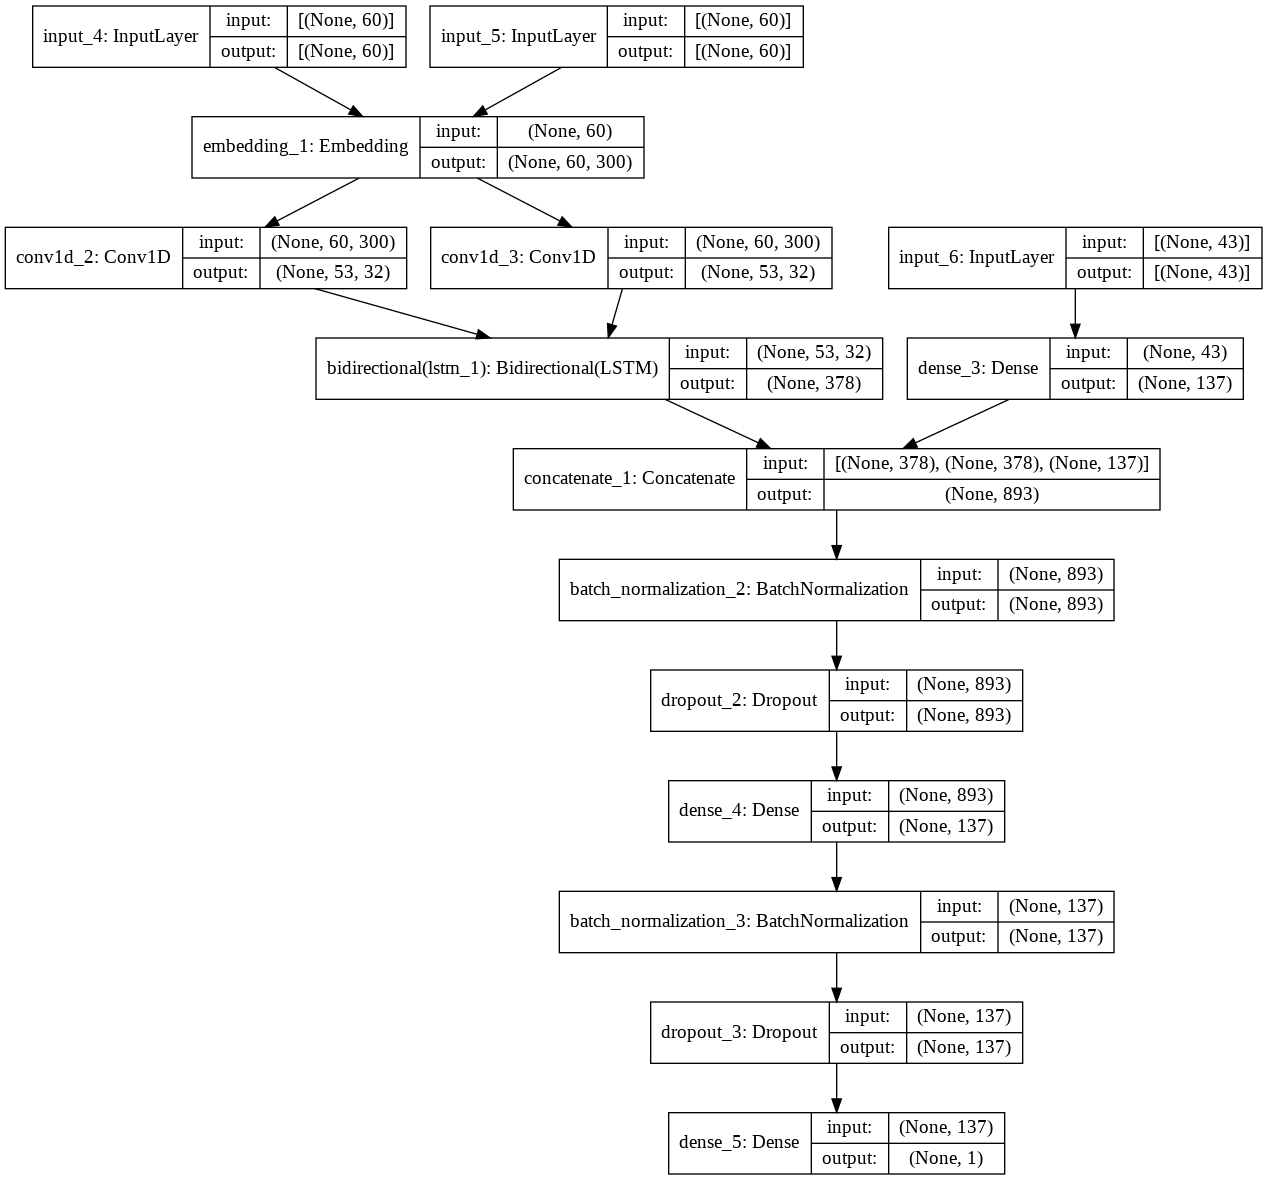

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:

# Set early stopping (large patience should be useful)
early_stopping =EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = '/content/drive/MyDrive/Project/lstm_featured.h5' 
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)


hist = model.fit([data_1_train, data_2_train, leaks_train], labels_train, \
        validation_data=([data_1_val, data_2_val, leaks_val], labels_val, weight_val), \
        epochs=2, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path) # sotre model parameters in .h5 file
bst_val_score = min(hist.history['val_loss'])

Epoch 1/2
356/356 [==============================] - 397s 992ms/step - loss: 0.3175 - acc: 0.8063 - val_loss: 0.2001 - val_acc: 0.8644
Epoch 2/2
356/356 [==============================] - 347s 975ms/step - loss: 0.1814 - acc: 0.8699 - val_loss: 0.1718 - val_acc: 0.8753


In [28]:

# Set early stopping (large patience should be useful)
early_stopping =EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = '/content/drive/MyDrive/Project/lstm_featured_new.h5' 
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)


history = model.fit([data_1_train, data_2_train, leaks_train], labels_train, \
        validation_data=([data_1_val, data_2_val, leaks_val], labels_val, weight_val), \
        epochs=4, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path) # sotre model parameters in .h5 file
bst_val_score = min(history.history['val_loss'])

Epoch 1/4
356/356 [==============================] - 360s 980ms/step - loss: 0.3051 - acc: 0.8098 - val_loss: 0.1942 - val_acc: 0.8433
Epoch 2/4
356/356 [==============================] - 339s 952ms/step - loss: 0.1811 - acc: 0.8697 - val_loss: 0.1723 - val_acc: 0.8792
Epoch 3/4
356/356 [==============================] - 336s 944ms/step - loss: 0.1674 - acc: 0.8797 - val_loss: 0.1879 - val_acc: 0.8452
Epoch 4/4
356/356 [==============================] - 333s 936ms/step - loss: 0.1587 - acc: 0.8854 - val_loss: 0.1945 - val_acc: 0.8524


In [23]:
import matplotlib.pyplot as plt

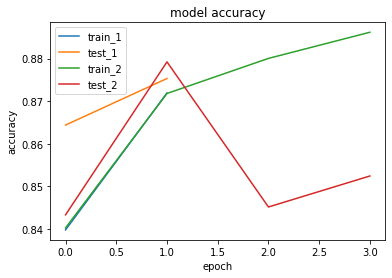

In [29]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_1', 'test_1','train_2', 'test_2'], loc='upper left')
plt.show()

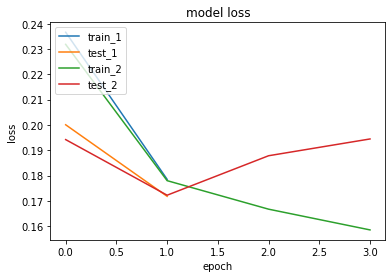

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_1', 'test_1','train_2', 'test_2'], loc='upper left')
plt.show()

In [32]:
bst_model_path = '/content/drive/MyDrive/Project/lstm_featured.h5'
model.load_weights(bst_model_path) # sotre model parameters in .h5 file

In [35]:
# Make the submission

print('Making the submission')

preds = model.predict([test_texts_1, test_texts_2, test_leaks], batch_size=8192, verbose=1)
preds += model.predict([test_texts_2, test_texts_1, test_leaks], batch_size=8192, verbose=1)
preds /= 2

submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
submission.to_csv('/content/drive/MyDrive/Project/lstm_featured_predicted.csv', index=False)

Making the submission
1/1 [==============================] - 0s 102ms/step


# Comparison Experiments
- Network Sturcutres 
  - We also changed the neural network structure to see if there is an improvement on the final score
    - Here the baseline is the `lstm_featured.ipynb`, which scores 0.16515
    - Add substract and multiply on **featured_lstm** feature
      - Scored 0.16674, no obvious improvements
    - Change N_DENSE to N_DENSE/2
      - Scored 0.16681 while 0.16515 is the baseline
    - Add Dense layer after merging features
      - Scored 0.1840 while 0.16515 is the baseline
